# Global Economic Incentive Routing
## Online Learning Model
### Prepared by BlockScience for Status

#### The goal of this notebook is to demonstrate the mechanism used to incentivize faster routing in the Status economic model. 

In [1]:
from decimal import Decimal
import numpy as np
import pandas as pd
from datetime import timedelta
import requests
import json
import datetime
from scipy import stats
from scipy.stats import gamma
from scipy.stats import powerlaw
import scipy.stats as stats
from scipy.odr import *
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sklearn import linear_model

from IPython.display import HTML
from matplotlib import animation, rc
rc('animation', html='jshtml', embed_limit=50)
from matplotlib import cm
import matplotlib.ticker as ticker

sns.set_style("whitegrid")

### Regressor

Given a set of solved routes, with two dimensions, distance and time.
Specifically, the distance is the routing distance from stored file to recipient and the time is time from request initiation to publishing proof of receipt.

In [2]:
# Uncorrelated random
dist = 10 * np.random.rand(100,1)
time = 5 * np.random.rand(100,1)

# Correlated random, time dependent on independent distance
dist = 10 * np.random.rand(100)
time = dist * np.random.normal(2,0.5, size =len(dist))
p_hat = np.random.rand(100) ** 3
print(time.max())
# pees = np.log( time  / (time.max()+0.01-time)) * np.random.normal(1,0.2)


32.34861433606859


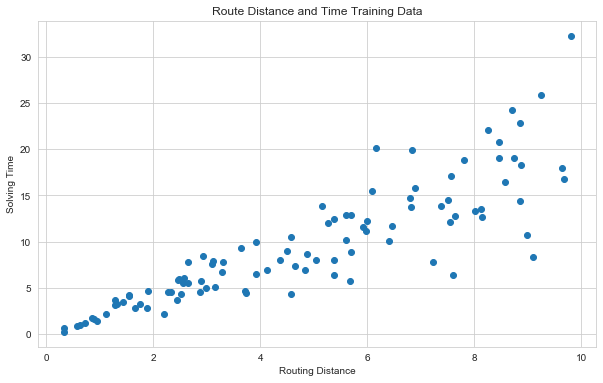

In [3]:
plt.figure(figsize=(10,6))
plt.scatter(dist, time)
plt.xlabel('Routing Distance')
plt.ylabel('Solving Time')
plt.title('Route Distance and Time Training Data')
dir_name = 'images/'
file_name = 'training'
plt.savefig(dir_name+file_name)
plt.show()

Linear Regression of Sample data

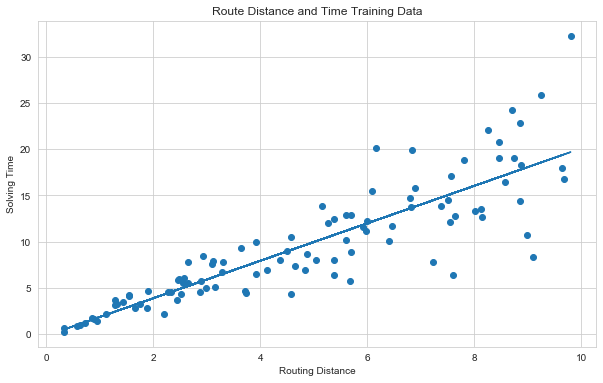

In [4]:
slope, intercept, r_value, p_value, std_err = stats.linregress(dist, time)

plt.figure(figsize=(10,6))
plt.scatter(dist, time)
plt.plot(dist, slope*dist + intercept)
plt.xlabel('Routing Distance')
plt.ylabel('Solving Time')
plt.title('Route Distance and Time Training Data')
dir_name = 'images/'
file_name = 'lin_regress'
plt.savefig(dir_name+file_name)
plt.show()

## Coordinate Transformation
Distance-Time Problem transformed from rectangular to polar coordinates.

Magnitude of the distance-time problem:

$ r = \sqrt{Dist^2 + Time^2}$

Angle between Distance and Time describes the expected 'skew' toward time:

$ \theta = \tan^{-1}(\frac{Time}{Dist})$

In [5]:
def cart_to_pol(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return(r, theta)

def pol_to_cart(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return(x, y)

def speed(dist,time):
    speed = dist/time
    theta = np.arctan2(1,speed)
    return theta

In [6]:
radii, angles = cart_to_pol(dist,time)

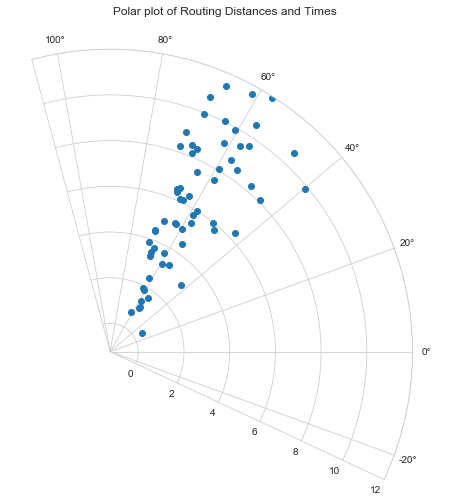

In [7]:
fig, ax = plt.subplots(figsize=(12,8))
ax = plt.subplot(111, projection='polar')
ax.scatter(angles, radii)
ax.set_rmax(12)
ax.set_rticks([0, 2,4,6,8,10,12])  # less radial ticks
ax.set_rlabel_position(60)  # get radial labels away from plotted line

ax.set_thetamin(-25)
ax.set_thetamax(105)

ax.grid(True)

ax.set_title("Polar plot of Routing Distances and Times", va='bottom')
dir_name = 'images/'
file_name = 'polar_trans'
plt.savefig(dir_name+file_name)
plt.show()

The angle is a calculation of the difference between routing distance and solving time. The coordinate transformation reduces the routing problem solving time to one dimension.

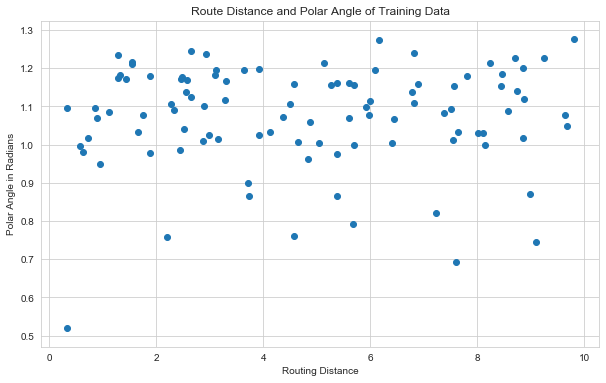

In [8]:
plt.figure(figsize=(10,6))
plt.scatter(dist, angles)
plt.xlabel('Routing Distance')
plt.ylabel('Polar Angle in Radians')
plt.title('Route Distance and Polar Angle of Training Data')
dir_name = 'images/'
file_name = 'angle_route'
plt.savefig(dir_name+file_name)
plt.show()

Calculate the z-score of the angles and view the distribution, where z-score is:

$$z_{score} = \frac{\theta_{new} - \mu}{\sigma}$$

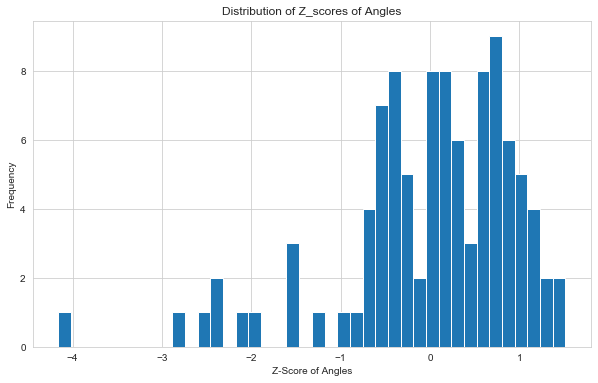

In [9]:
zees = stats.zscore(angles)

plt.figure(figsize=(10,6))
plt.hist(zees, bins = 40)
plt.xlabel('Z-Score of Angles')
plt.ylabel('Frequency')
plt.title('Distribution of Z_scores of Angles')
dir_name = 'images/'
file_name = 'angle_route'
plt.savefig(dir_name+file_name)
plt.show()

Introduce new route, with new distance and new time.

In [10]:
dist_new = 10 * np.random.rand()
time_new = dist_new * np.random.rand()

Calculate new angle of new route, $\theta_{new}$

In [11]:
radius_new, angle_new = cart_to_pol(dist_new, time_new)

In [12]:
df = pd.DataFrame(zees, columns = ['zees'])
df['angles'] = angles

df.sort_values(by=['angles'], inplace =True)

Interpolate the actual $z_{score}$ of the $\theta_{new}$ :

In [13]:
actual_zee = np.interp(angle_new, df.angles, df.zees)
actual_zee

-4.161118222445364

New Route is appended to the set of angles

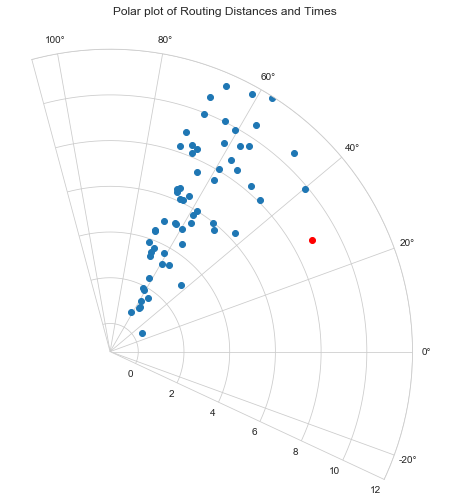

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
ax = plt.subplot(111, projection='polar')
ax.scatter(angles, radii)
ax.scatter( angle_new,radius_new,color='r')
ax.set_rmax(12)
ax.set_rticks([0, 2,4,6,8,10,12])  # less radial ticks
ax.set_rlabel_position(60)  # get radial labels away from plotted line

ax.set_thetamin(-25)
ax.set_thetamax(105)

ax.grid(True)

ax.set_title("Polar plot of Routing Distances and Times", va='bottom')
dir_name = 'images/'
file_name = 'polar_with_new_point'
plt.savefig(dir_name+file_name)
plt.show()

Inlcude new solved route into angles and compute new set of z_scores for all routes

In [15]:
angles_appended = np.append(angles, angle_new)

zees_appended = stats.zscore(angles_appended)

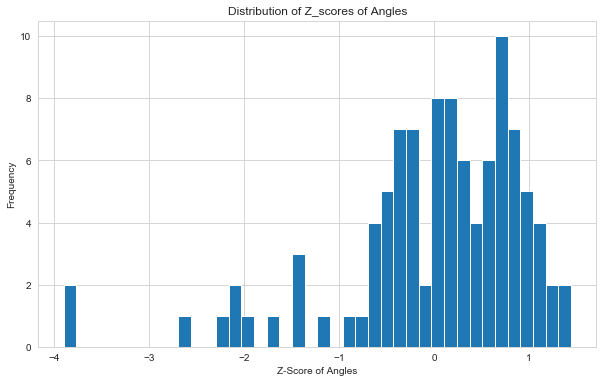

In [16]:
plt.figure(figsize=(10,6))
plt.hist(zees_appended, bins = 40)
plt.xlabel('Z-Score of Angles')
plt.ylabel('Frequency')
plt.title('Distribution of Z_scores of Angles')
dir_name = 'images/'
file_name = 'angle_route'
plt.savefig(dir_name+file_name)
plt.show()

Get expected z_score of the route posterior to providing the information:

In [17]:
exp_zee = zees_appended[-1]

In [18]:
exp_zee

-3.90284627975723

Compute the gradient as:

$$ Gradient = z_{score-actual} - z_{score-expected} $$

In [19]:
diff =  ( actual_zee - exp_zee )
diff

-0.25827194268813347

In [20]:
def incentive(diff):
    if diff > 0:
#         tax = np.array(params['tax_%'], dtype = float) * diff * np.array(escrow, dtype = float)
        tax = diff
        subsidy = 0
    else:
        diff = np.abs(diff)
#         subsidy_from_treasury = np.array(params['subsidy_treasury'], dtype = float) * diff * prev_state['treasury']
#         subsidy_from_escrow = np.array(params['subsidy_escrow'], dtype = float) * diff * np.array(escrow, dtype = float)
#         subsidy = min(subsidy_from_treasury, subsidy_from_escrow)
        subsidy = diff
        tax = 0
    return tax, subsidy

In [21]:
tax, subsidy = incentive(diff)
print('tax = ',tax, ' subsidy = ',subsidy)

tax =  0  subsidy =  0.25827194268813347


In [22]:
df_app = pd.DataFrame(zees_appended, columns = ['zees'])
df_app['angles'] = angles_appended

df_app.sort_values(by=['angles'], inplace =True)

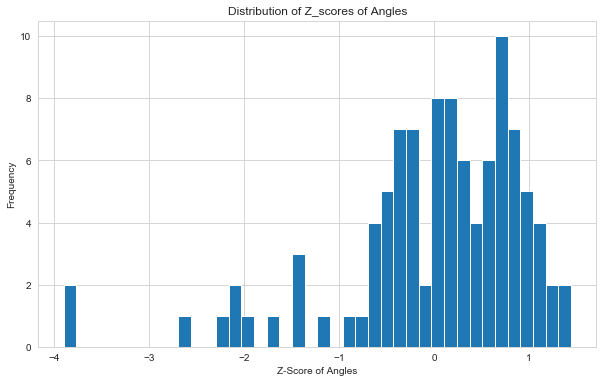

In [23]:
plt.figure(figsize=(10,6))
plt.hist(df_app.zees,  bins = 40)
plt.xlabel('Z-Score of Angles')
plt.ylabel('Frequency')
plt.title('Distribution of Z_scores of Angles')
dir_name = 'images/'
file_name = 'angle_route'
plt.savefig(dir_name+file_name)
plt.show()

C:\Users\mbarl\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\mbarl\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


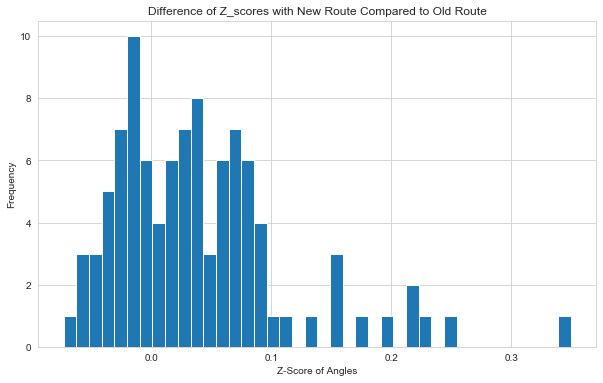

In [24]:
plt.figure(figsize=(10,6))
if diff > 0:
    plt.hist(df.zees - df_app.zees[0:len(df.zees)], bins = 40)
else:
    plt.hist(df_app.zees[0:len(df.zees)] - df.zees, bins = 40)

plt.xlabel('Z-Score of Angles')
plt.ylabel('Frequency')
plt.title('Difference of Z_scores with New Route Compared to Old Route')
dir_name = 'images/'
file_name = 'angle_route'
plt.savefig(dir_name+file_name)
plt.show()

### Classifier

Using the route dataset, we seek to classify a route as fake or not. A classical classifier could make a distinct determination as to whether a route is definitively real or fake. Here, we make a probabilistic determination on each route.

#### Logistic Regression as a Classifier

Logistic growth curve in the family of sigmoid curves, has the parent function:
$$f(x) = \frac{L}{1 + e^{(-k(x-x_0))}}$$

where

$x_0$ = the x-value of the sigmoid's midpoint,

L = the function's maximum value (y-value), and

k = the logistic growth rate or steepness of the curve

The derivative of a logistic curve in this form is:

$$\frac{df}{dx} = k \cdot f(x)\cdot(1 - \frac{f(x)}{L})$$

Logistic Regression

$$\log {\frac{p}{1-p}} = b_0 + b_1 \cdot x$$


In [25]:
def log_growth(x, L, k, x0):
    '''x= input array
       L = function maximum value
       k = rate
       x0 = x-value to reach 1/2*L'''

    func_val = L / (1 + np.exp(-k*(x-x0)))
    
    deriv = k * func_val * (1 - func_val / L)

    return func_val, deriv

In [26]:
x = angles_appended

In [27]:
L = 1
x0 = 0
k = 10  # 0.003 # was 0.01
time_to_max = 5 / k
time_to_max

0.5

In [28]:
func_out, deriv_out = log_growth(x, L, k, x0)

Text(0.5, 1.0, 'Plot of Sigmoid Function')

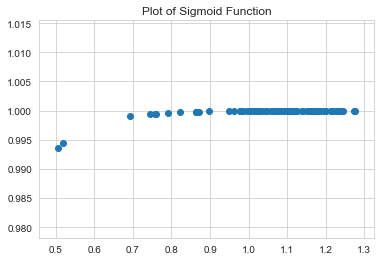

In [29]:
plt.scatter(x,func_out)
plt.title('Plot of Sigmoid Function')

Text(0.5, 1.0, 'Plot of Sigmoid Derivative')

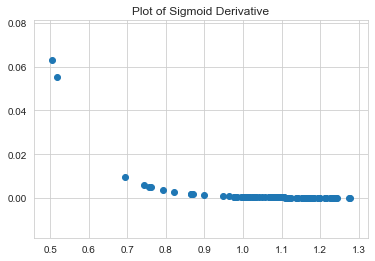

In [30]:
plt.scatter(x,deriv_out)
plt.title('Plot of Sigmoid Derivative')

In [31]:
def log_growth_shift(x, L, x_max, x0):
    '''x= input array
       L = maximum value
       x_max = x value when f(x) nears L (99.4%)
       x0 = x-value to reach 1/2*L'''
    k = 5 / (x_max - x0)
    func_val = L / (1 + np.exp(-k*(x-x0)))
      # fix only once!- except if repeated should do it

    deriv = k * func_val * (1 - func_val / L)
    
#    initial_condition = f(0)
# need if using derivative to determine f(x) + C
    initial_condition =  L / (1 + np.exp(-k*(0-x0)))
 # probably deriv + C
    return func_val, deriv, initial_condition

In [32]:
x_max = 1
shift_func, shift_deriv, shift_ic = log_growth_shift(x, L, x_max, x0)

Text(0.5, 1.0, 'Plot of Sigmoid Function')

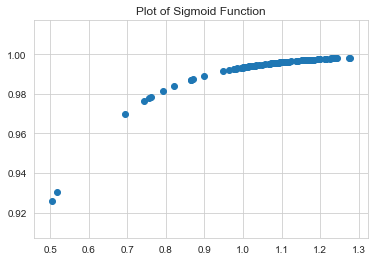

In [33]:
plt.scatter(x,shift_func)
plt.title('Plot of Sigmoid Function')

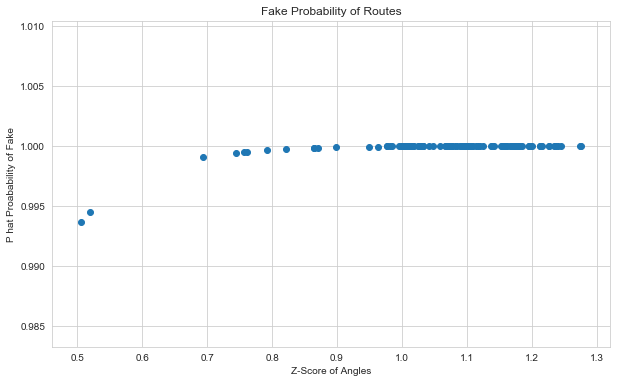

In [34]:
plt.figure(figsize=(10,6))
plt.scatter(x, func_out)
plt.xlabel('Z-Score of Angles')
plt.ylabel('P hat Proabability of Fake')
plt.title('Fake Probability of Routes')
dir_name = 'images/'
file_name = 'fake'
plt.savefig(dir_name+file_name)
plt.show()

In [35]:


def estimate_coef(x, y): 
    # number of observations/points 
    n = np.size(x) 
  
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return(b_0, b_1) 

In [36]:
def plot_regression_line(x, y, b): 
    # plotting the actual points as scatter plot 
    plt.scatter(x, y, color = "m", 
               marker = "o", s = 30) 
  
    # predicted response vector 
    y_pred = b[0] + b[1]*x 
  
    # plotting the regression line 
    plt.plot(x, y_pred, color = "g") 
  
    # putting labels 
    plt.xlabel('x') 
    plt.ylabel('y') 
  
    # function to show plot 
    plt.show() 

In [37]:
pees =  1/np.e * np.exp(1-time)# * np.random.rand()**(1/2) 
df_pees = pd.DataFrame(angles, columns = ['angles'])
df_pees.sort_values(by=['angles'], inplace =True)

In [38]:
df_pees['pees'] = pees

In [39]:
b = estimate_coef(df_pees.angles, df_pees.pees)

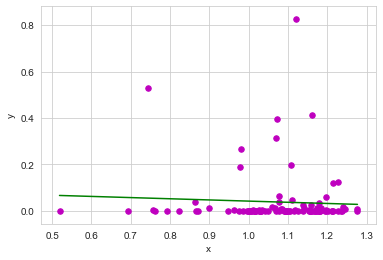

In [40]:
plot_regression_line(df_pees.angles, df_pees.pees, b)

In [41]:
df_pees.head()

,angles,pees
59,0.518793,1.190465e-03
84,0.693818,3.980042e-04
67,0.743896,5.271475e-01
93,0.757294,3.349780e-03
76,0.760607,8.936661e-15


In [42]:
def log_res(x,y):
    # number of observations/points 
    n = np.size(x) 
  
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    
    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    

    return(b_0, b_1)

In [43]:
from sklearn import datasets
iris = datasets.load_iris()

X = iris.data[:, :2]
y = (iris.target != 0) * 1

In [44]:
y = (iris.target != 0) * 1
y = np.flip(y)
y = y[:100]
y[20:] = 0
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [45]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True, verbose=False):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.verbose = verbose
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient
            
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            loss = self.__loss(h, y)
                
            if(self.verbose ==True and i % 10000 == 0):
                print(f'loss: {loss} \t')
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X):
        return self.predict_prob(X).round()

In [46]:
model = LogisticRegression(lr=0.1, num_iter=3000)

In [47]:
# test_time = dist * np.random.rand(100)
# y = 1/np.e * np.exp(1-test_time)
X = np.array(df_pees)
# y = pees
model.fit(X, y)

In [48]:
preds = model.predict(X)
(preds == y).mean()

0.84

In [49]:
model.theta

array([ 3.91943562, -5.15649444,  0.59313101])

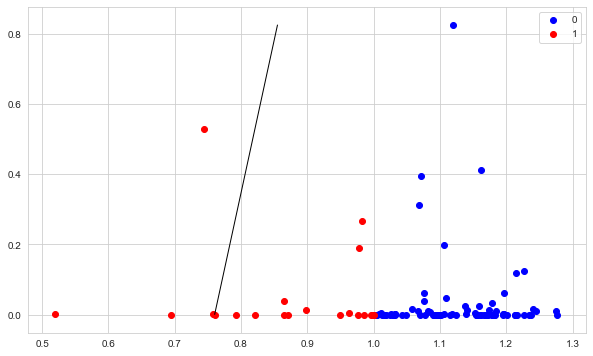

In [50]:
plt.figure(figsize=(10, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='b', label='0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='r', label='1')
plt.legend()
x1_min, x1_max = X[:,0].min(), X[:,0].max(),
x2_min, x2_max = X[:,1].min(), X[:,1].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
grid = np.c_[xx1.ravel(), xx2.ravel()]
probs = model.predict_prob(grid).reshape(xx1.shape)
plt.contour(xx1, xx2, probs, [0.5], linewidths=1, colors='black');

In [51]:
f_fake = np.array(np.random.rand(100))

f_not_fake = 1 - f_fake

In [52]:
# plt.figure(figsize=(16,8))
# plt.subplot(1,2,1)
# plt.hist(f_fake, bins = 20)
# plt.xlabel('Z-Score of Angles')
# plt.ylabel('Frequency')
# plt.title('Frequency of Fake Routes')

# plt.subplot(1,2,2)
# plt.hist(f_not_fake, bins = 20)
# plt.xlabel('Z-Score of Angles')
# plt.ylabel('Frequency')
# plt.title('Frequency of Not Fake Routes')
# plt.show()

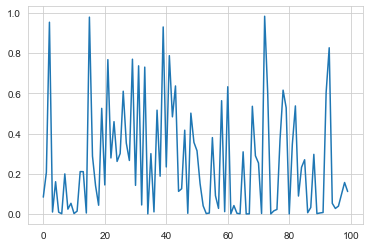

In [53]:
plt.plot(p_hat)

In [54]:
df = pd.DataFrame(data = dist, columns = ['dist'])
df['time'] = time
df['zees'] = zees
df['angles'] = angles
df['fake'] = p_hat

In [55]:
df.head()

,dist,time,zees,angles,fake
0,3.277332,6.733411,0.327289,1.117823,0.083577
1,2.649333,7.829048,1.276410,1.244495,0.206602
2,0.329505,0.640275,0.160120,1.095513,0.953735
3,2.884868,5.698861,0.210124,1.102186,0.009461
4,9.800957,32.348614,1.517032,1.276609,0.160213


In [56]:
fake_df =  df[df.fake > 0.75]
real_df = df[df.fake <= 0.75]
# f_not_fake = 1 - f_fake

### Distribution of Fake and Not Fake Routes

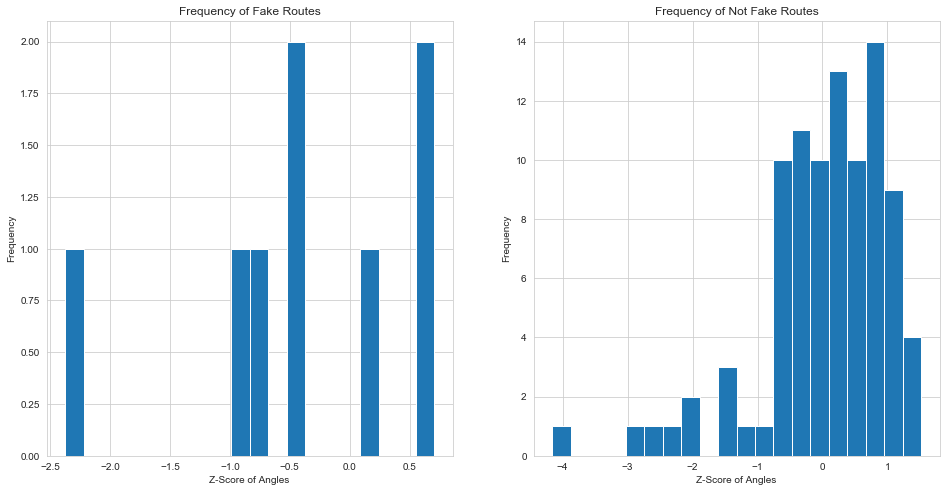

In [57]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.hist(fake_df.zees, bins = 20)
plt.xlabel('Z-Score of Angles')
plt.ylabel('Frequency')
plt.title('Frequency of Fake Routes')

plt.subplot(1,2,2)
plt.hist(real_df.zees, bins = 20)
plt.xlabel('Z-Score of Angles')
plt.ylabel('Frequency')
plt.title('Frequency of Not Fake Routes')
plt.show()

In [58]:
fake_df = fake_df.copy()
real_df = real_df.copy()

fake_df.sort_values(by=['angles'], inplace =True)
real_df.sort_values(by=['angles'], inplace =True)

new_zees = stats.zscore(fake_df.angles)
real_new_zees = stats.zscore(real_df.angles)
# fake_df['new_zees'] = fake_df.apply(lambda x: stats.zscore(fake_df.angles))
fake_df['new_zees'] = new_zees
real_df['new_zees'] = real_new_zees

In [59]:
fake_df

,dist,time,zees,angles,fake,new_zees
93,2.207032,2.086337,-2.374084,0.757294,0.826715,-2.116333
15,0.949044,1.323177,-0.940747,0.948589,0.979051,-0.559105
41,0.622446,0.931454,-0.692674,0.981697,0.787451,-0.289591
39,0.720737,1.163806,-0.433319,1.016311,0.930156,-0.007818
72,8.847857,14.347164,-0.419245,1.018190,0.983522,0.007472
2,0.329505,0.640275,0.160120,1.095513,0.953735,0.636915
21,8.452331,19.014314,0.587151,1.152505,0.767634,1.100856
29,2.567607,6.027185,0.703815,1.168075,0.769799,1.227604


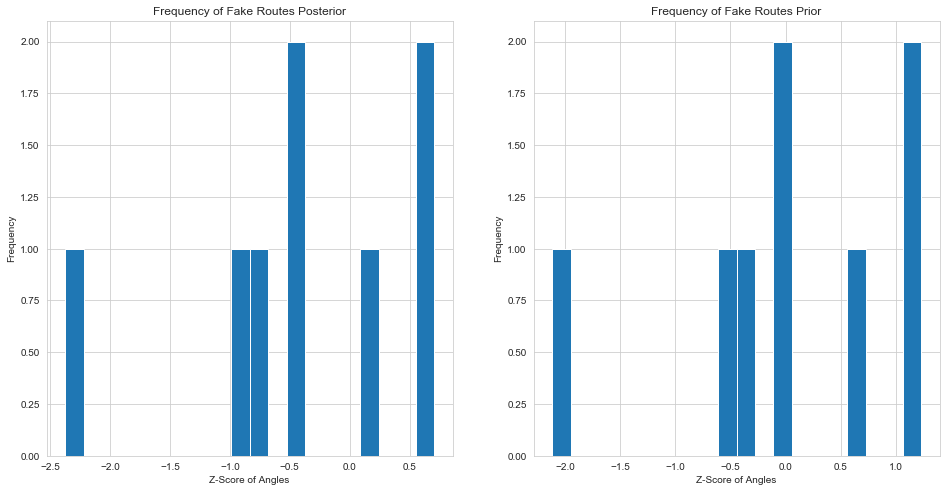

In [60]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.hist(fake_df.zees, bins = 20)
plt.xlabel('Z-Score of Angles')
plt.ylabel('Frequency')
plt.title('Frequency of Fake Routes Posterior')

plt.subplot(1,2,2)
plt.hist(fake_df.new_zees, bins = 20)
plt.xlabel('Z-Score of Angles')
plt.ylabel('Frequency')
plt.title('Frequency of Fake Routes Prior')
plt.show()

In [61]:
dist_new = 10 * np.random.rand()
time_new = dist_new * np.random.normal(2,0.5)
p_hat_new = np.random.rand() ** 3
radius_new, angle_new = cart_to_pol(dist_new, time_new)

In [62]:
# Watch re-sort!
fake_zee = np.interp(angle_new, fake_df.angles, fake_df.new_zees)
fake_zee
real_zee = np.interp(angle_new, real_df.angles, real_df.zees)
real_zee

0.3940655617535633

In [63]:
# p_star = fake_zee * len(fake_df) 
# p_star

In [64]:
data = fake_df.new_zees
# sort the data:
data_sorted = np.sort(data)

# calculate the proportional values of samples
p = 1. * np.arange(len(data)) / (len(data) - 1)

data = real_df.zees
# sort the data:
data_sorted = np.sort(data)

# calculate the proportional values of samples
q = 1. * np.arange(len(data)) / (len(data) - 1)

In [65]:
fake_df['cdf'] = p
real_df['cdf'] = q

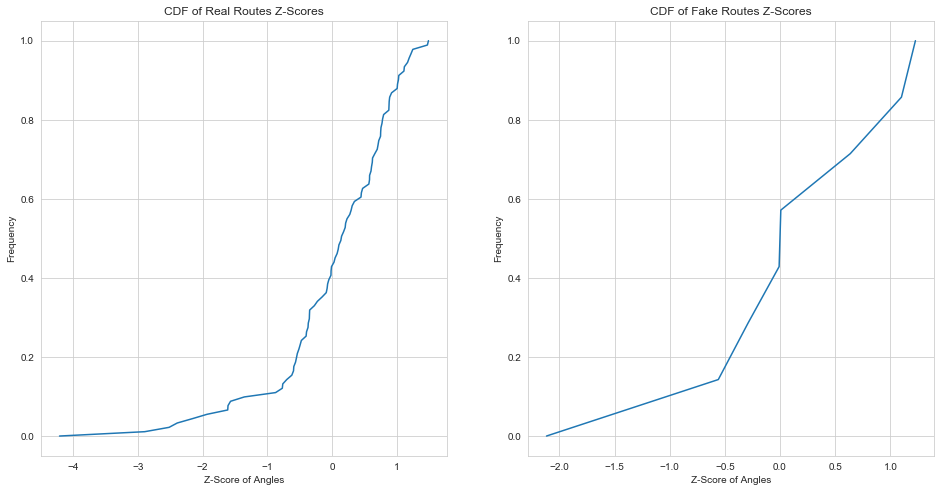

In [66]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(real_df.new_zees, real_df.cdf)
plt.xlabel('Z-Score of Angles')
plt.ylabel('Frequency')
plt.title('CDF of Real Routes Z-Scores')

plt.subplot(1,2,2)
plt.plot(fake_df.new_zees, fake_df.cdf)
plt.xlabel('Z-Score of Angles')
plt.ylabel('Frequency')
plt.title('CDF of Fake Routes Z-Scores')
plt.show()
plt.show()

### New Route Prediction

In [67]:
fake_zee = np.interp(angle_new, fake_df.angles, fake_df.new_zees)
fake_dir = np.interp(fake_zee, fake_df.new_zees, fake_df.cdf)

In [68]:
fake_dir

0.7925488972632784

In [69]:
real_zee = np.interp(angle_new, real_df.angles, real_df.zees)
real_dir = np.interp(real_zee, real_df.new_zees, real_df.cdf)
real_dir

0.599110589495669

In [70]:
fake_pdf = stats.norm(fake_df.new_zees.mean(), fake_df.new_zees.std())

In [71]:
fake_star = fake_pdf.pdf(fake_zee)

In [72]:
real_pdf = stats.norm(real_df.zees.mean(), real_df.new_zees.std())

In [73]:
real_star = real_pdf.pdf(real_zee)
real_star

0.37252954333475513

In [74]:
denom = len(fake_df) + len(real_df)
p_hat_star = fake_star * len(fake_df) / denom + real_star * len(real_df) / denom  

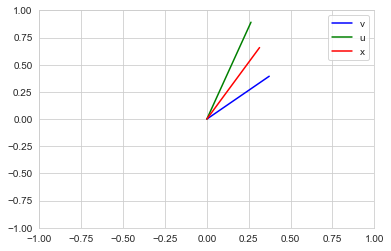

In [75]:
# Redo with law of cosines
# vector u
u = np.array([fake_star, fake_zee])
u_squared = (np.matrix.transpose(u)@u)
u_norm = np.linalg.norm(u)

# vector v
v = np.array([ real_star, real_zee ])
v_squared = (np.matrix.transpose(v)@v)
v_norm = np.linalg.norm(v)

dot_prod = np.dot(v,u)

# angle
theta = np.arccos(dot_prod / ( v_norm * u_norm ))

x = theta * v + (1 - theta) * u

# draw
plt.plot([0, v[0]],[0, v[1]],'b',label='v')
plt.plot([0, u[0]],[0, u[1]],'g',label='u')
plt.plot([0, x[0]],[0, x[1]],'r',label='x')

plt.legend()
plt.axis((-1, 1,-1, 1))

plt.show()

In [76]:
u_norm**2

0.8635431323574961

In [77]:
u_squared

0.8635431323574961

In [78]:
dot_prod

0.4493660276097672

In [79]:
theta * 180 / np.pi

26.90790390395192

In [80]:
p_hat_star = theta * 2 / np.pi

In [81]:
x

array([0.31478917, 0.65766706])

### Fake Penalty Function

In [82]:
fake_penalty = p_hat_star**5

In [83]:
fake_penalty

0.002388838517093393